# TITLE

### Intro

### Methods and Results

The most appropriate method for investigating whether or not time of day of sessions, total time played, and age are predictive of newsletter subscription would be knn classification. Our question is pretty clearly a classification question, so it makes sense to use the classificaiton method learned in class. The knn model will have to scale and center all of the variables, but doing so requires the assumption that all of the predictor values are equally important in predicting subscription status, which likely isn't true. In order to train the knn model, we will have to split the data (after it has been wrangled) into training and testing, but the exact ratio of that split is something that can be decided later. As for the wrangling itself, we'll need to at least do what we mentioned in the question section, and it may be helpful to select only the columns in the combined dataset that are relevant to our question. Lastly, we will use cross-validation in the training of the model to determine the ideal number of neighbours. Of course the usefulness of the model will likely be limited by the relatively small dataset (less than 200 participants), but there's nothing we can do about that.

In [1]:
#loading in data and doing some wrangling
library(tidyverse)
library(tidymodels)
if (!dir.exists("data")) {
    dir.create("data")
}

download.file("https://raw.githubusercontent.com/nt8669/DSCI-100-007-24-Project/refs/heads/main/data/players.csv", "data/players.csv")
download.file("https://raw.githubusercontent.com/nt8669/DSCI-100-007-24-Project/refs/heads/main/data/sessions.csv", "data/sessions.csv")

players_data <- read_csv("data/players.csv")
sessions_data <- read_csv("data/sessions.csv")

sessions_data <- sessions_data |>
    mutate(start_time = as.POSIXlt(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(end_time = as.POSIXlt(end_time, format = "%d/%m/%Y %H:%M"))
players_data <- players_data |>
    mutate(experience = as.factor(experience)) |>
    mutate(gender = as.factor(gender))

combined_data <- full_join(players_data, sessions_data, by = "hashedEmail") |>
    mutate(has_played = !is.na(start_time)) |>
    select(-original_start_time, -original_end_time)
head(combined_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age,start_time,end_time,has_played
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dttm>,<dttm>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 00:21:00,2024-08-08 01:35:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-09 22:30:00,2024-09-09 22:37:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 02:41:00,2024-08-08 03:25:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-10 15:07:00,2024-09-10 15:29:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-05-05 22:21:00,2024-05-05 23:17:00,TRUE
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-04-06 22:24:00,2024-04-06 23:33:00,TRUE


### Summary

In [2]:
#finding the middle time of each play session
combined_data <- mutate(combined_data, mid_time = start_time + (end_time - start_time) / 2, 
                        mid_time_dateless = format(mid_time, "%H:%M:%S") |>
                        as.POSIXct(format = "%H:%M:%S")) |>
    filter(!is.na(Age))
#midtime datelss just sets the date to today so we can look at only time
# This one was really unintuitive and weird (why can't you add POSIXt objects??)
head(combined_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,start_time,end_time,has_played,mid_time,mid_time_dateless
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dttm>,<dttm>,<lgl>,<dttm>,<dttm>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 00:21:00,2024-08-08 01:35:00,TRUE,2024-08-08 00:58:00,2025-04-04 00:58:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-09 22:30:00,2024-09-09 22:37:00,TRUE,2024-09-09 22:33:30,2025-04-04 22:33:30
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-08-08 02:41:00,2024-08-08 03:25:00,TRUE,2024-08-08 03:03:00,2025-04-04 03:03:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-09-10 15:07:00,2024-09-10 15:29:00,TRUE,2024-09-10 15:18:00,2025-04-04 15:18:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-05-05 22:21:00,2024-05-05 23:17:00,TRUE,2024-05-05 22:49:00,2025-04-04 22:49:00
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,2024-04-06 22:24:00,2024-04-06 23:33:00,TRUE,2024-04-06 22:58:30,2025-04-04 22:58:30


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


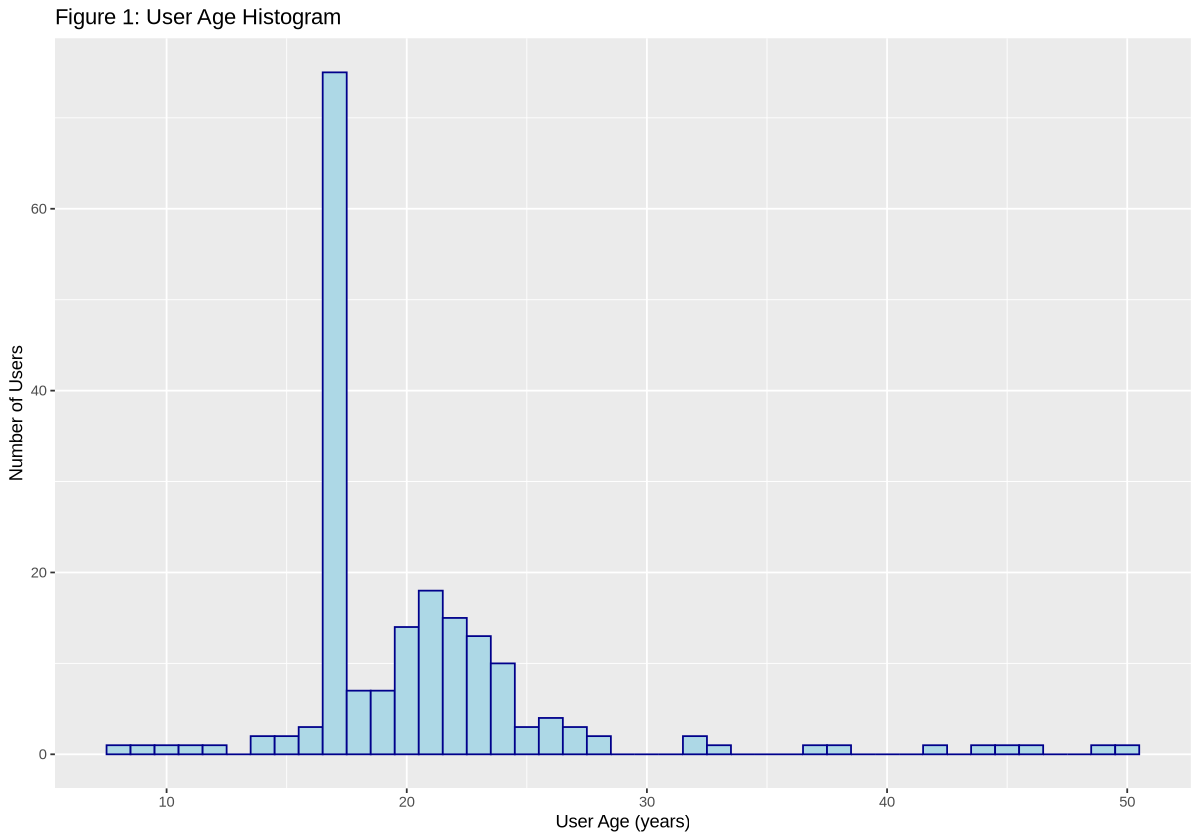

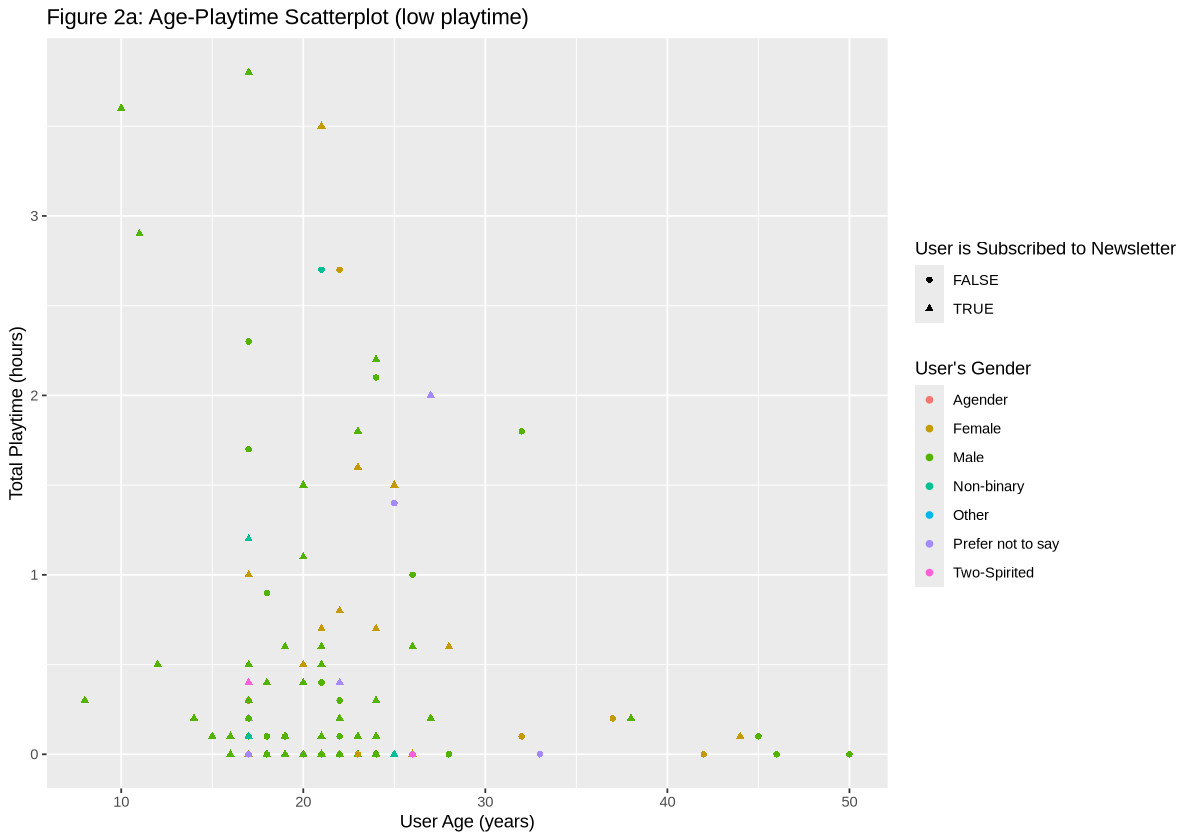

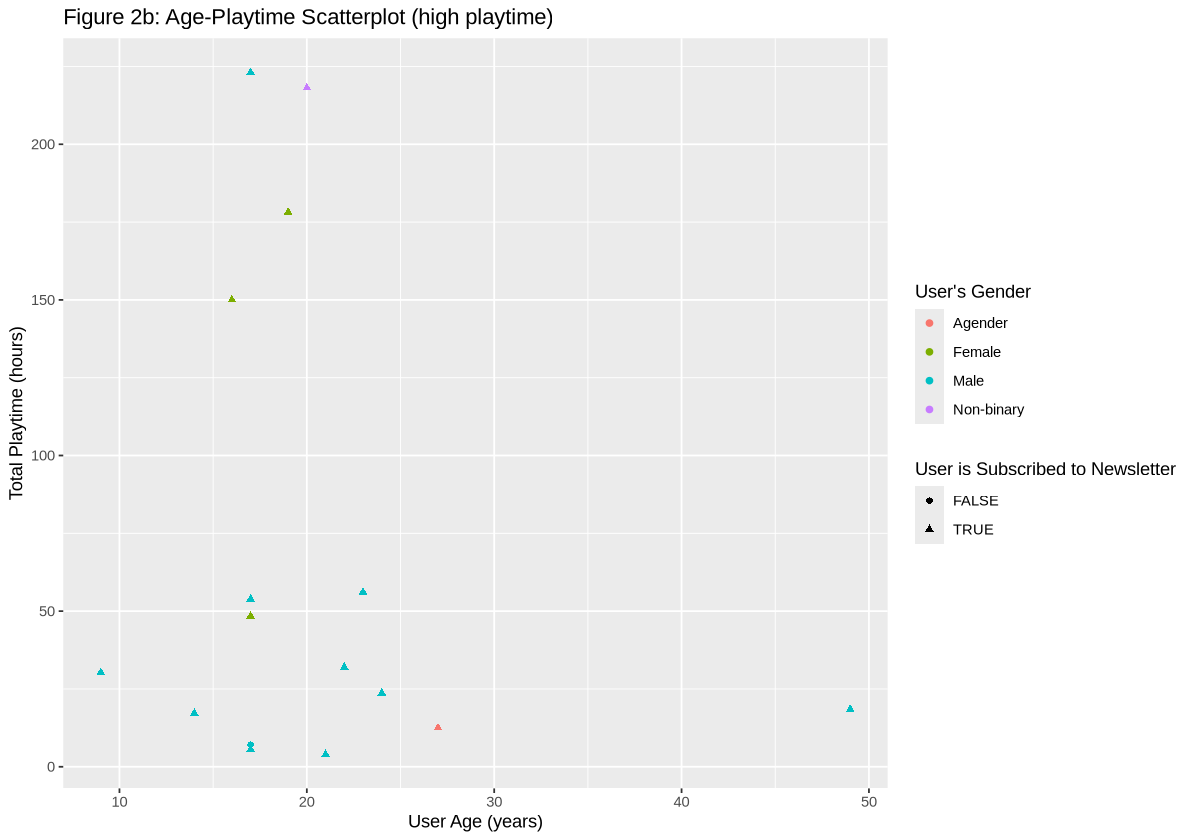

Warning message:
“Removed 73 rows containing non-finite outside the scale range (`stat_bin()`).”


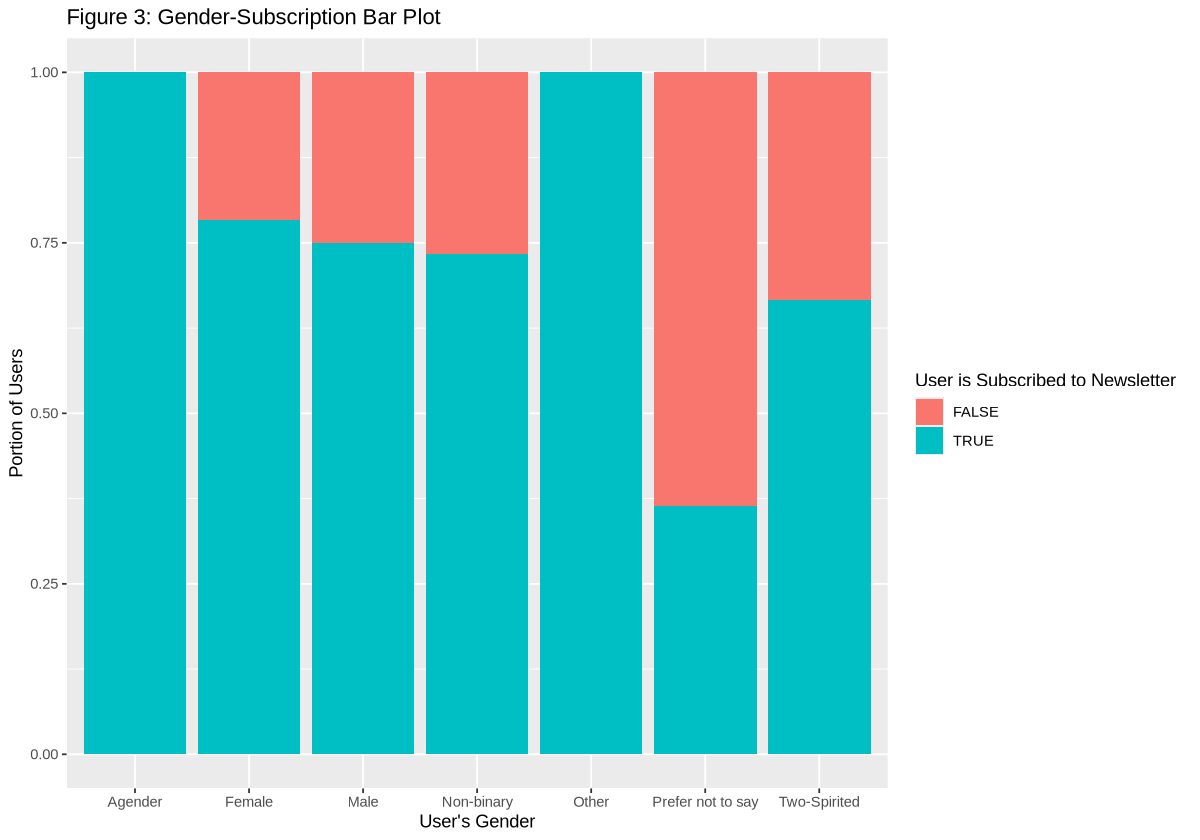

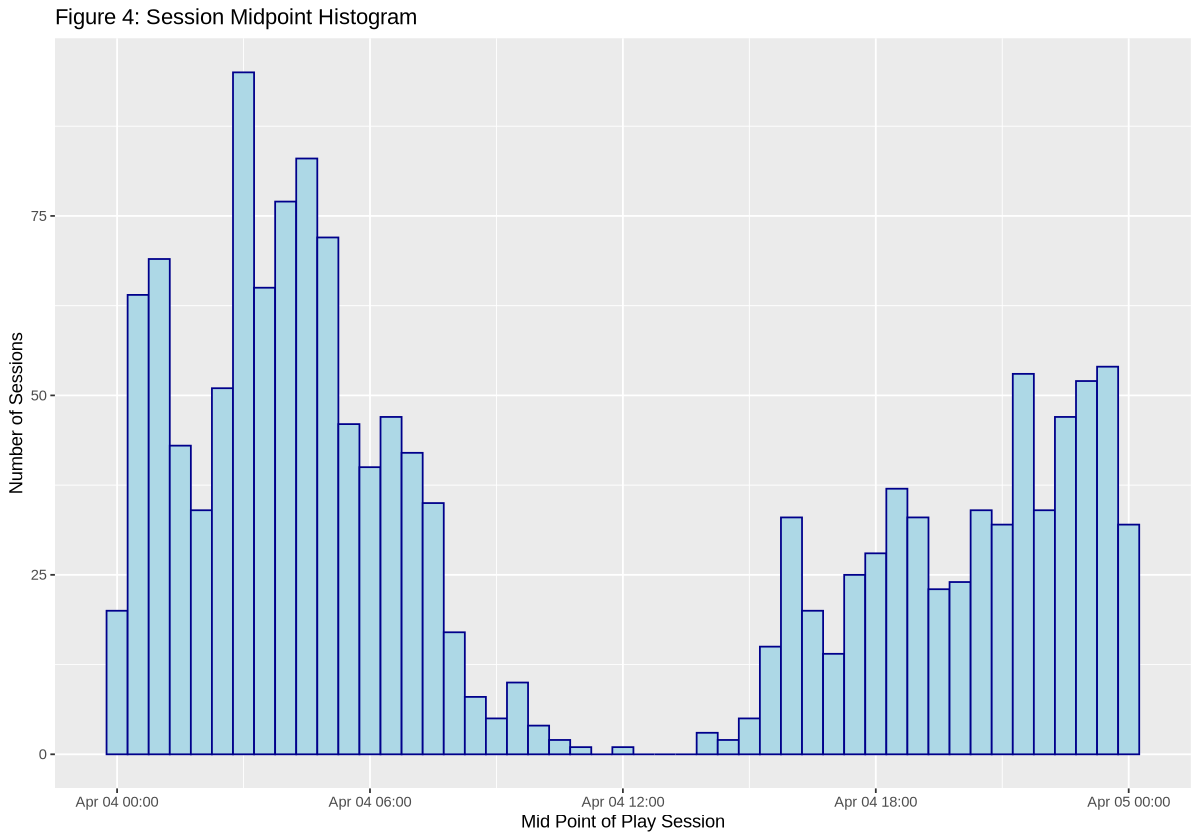

In [3]:
#Plots
options(repr.plot.width = 10)

age_hist <- players_data |>
    ggplot(aes(x = Age)) +
    geom_histogram(color = "dark blue", fill = "light blue", binwidth = 1) +
    labs(x = "User Age (years)", y = "Number of Users", title = "Figure 1: User Age Histogram")

age_v_playtime_low <- players_data |> 
    filter(played_hours < 4) |>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_point(aes(shape = subscribe, color = gender)) +
    labs(y = "Total Playtime (hours)", x = "User Age (years)", title = "Figure 2a: Age-Playtime Scatterplot (low playtime)",
         color = "User's Gender", shape = "User is Subscribed to Newsletter")

age_v_playtime_high <- players_data |> 
    filter(played_hours >= 4) |>
    ggplot(aes(x = Age, y = played_hours)) +
    geom_point(aes(shape = subscribe, color = gender)) +
    labs(y = "Total Playtime (hours)", x = "User Age (years)", title = "Figure 2b: Age-Playtime Scatterplot (high playtime)",
         color = "User's Gender", shape = "User is Subscribed to Newsletter")

players_bar <- players_data |>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "User's Gender", y = "Portion of Users", 
         fill = "User is Subscribed to Newsletter",
         title = "Figure 3: Gender-Subscription Bar Plot")

mid_time_hist <- combined_data |>
    ggplot(aes(x = mid_time_dateless)) +
    geom_histogram(color = "dark blue", fill = "light blue", binwidth = 1800) +
    labs(x = "Mid Point of Play Session", y = "Number of Sessions", title = "Figure 4: Session Midpoint Histogram")

age_hist
age_v_playtime_low
age_v_playtime_high
players_bar
mid_time_hist

In [9]:
model_data <- combined_data |>
    filter(has_played == TRUE) |>
    group_by(hashedEmail) |>
    summarize(mean_mid_time = mean(mid_time_dateless)) |>
    full_join(players_data, by = "hashedEmail") |>
    mutate(mean_mid_time = as.POSIXct(mean_mid_time),
          subscribe = as.factor(subscribe)) |>
    filter(!is.na(mean_mid_time))
head(model_data)

hashedEmail,mean_mid_time,experience,subscribe,played_hours,name,gender,Age
<chr>,<dttm>,<fct>,<fct>,<dbl>,<chr>,<fct>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2025-04-04 12:13:30,Regular,TRUE,1.5,Isaac,Male,20
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,2025-04-04 04:43:00,Pro,FALSE,0.4,Lyra,Male,21
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,2025-04-04 21:06:30,Beginner,TRUE,0.1,Osiris,Male,17
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,2025-04-04 10:50:32,Regular,TRUE,5.6,Winslow,Male,17
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2025-04-04 20:21:30,Pro,TRUE,1.0,Knox,Male,17
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,2025-04-04 08:01:00,Veteran,FALSE,0.1,Callum,Male,19


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6210131,3,0.03832784,Preprocessor1_Model01
2,accuracy,binary,0.6210131,3,0.03832784,Preprocessor1_Model02
3,accuracy,binary,0.6039191,3,0.01855326,Preprocessor1_Model03
4,accuracy,binary,0.6039191,3,0.01855326,Preprocessor1_Model04
5,accuracy,binary,0.6779237,3,0.01006471,Preprocessor1_Model05
6,accuracy,binary,0.6779237,3,0.01006471,Preprocessor1_Model06


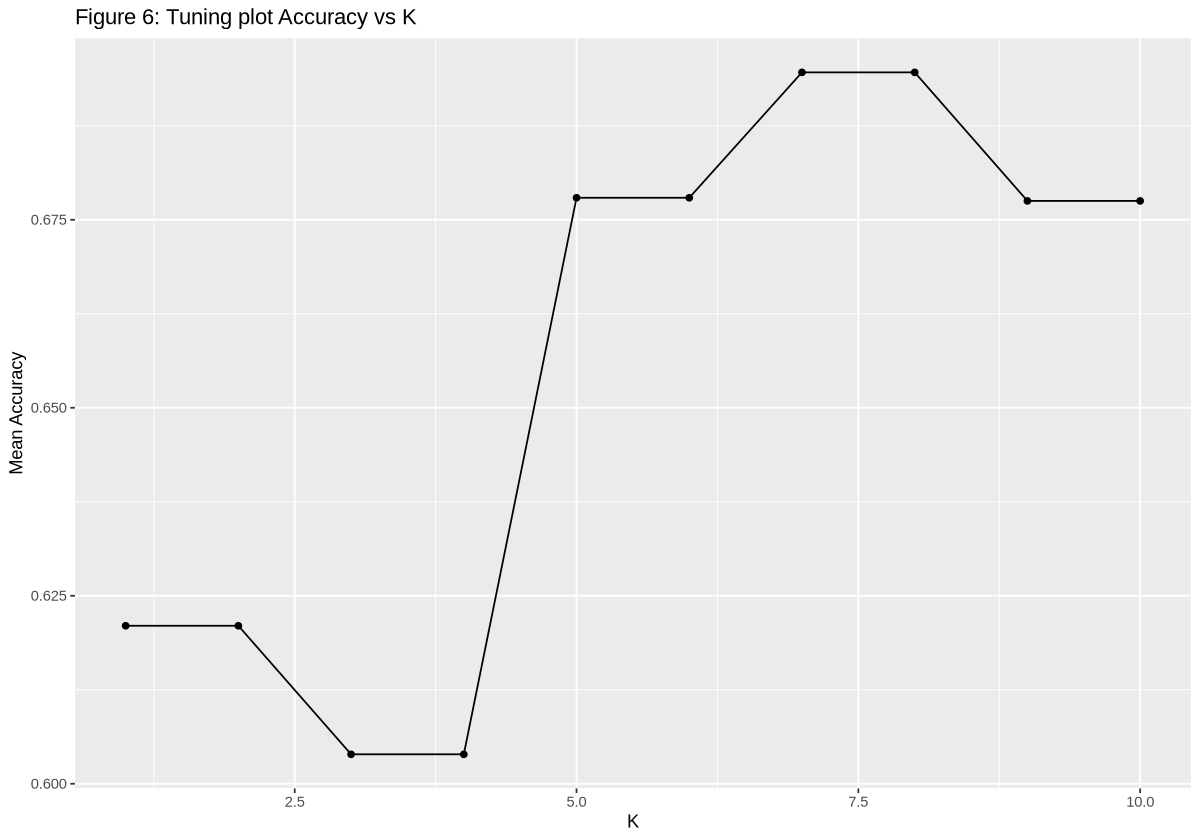

In [11]:
set.seed(10844538)
combined_split <- initial_split(model_data, 0.85, strata = subscribe)
combined_training <- training(combined_split)
combined_testing <- testing(combined_split)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

#this sucked man
combined_recipe <- recipe(subscribe ~ Age+played_hours+mean_mid_time, data = model_data) |>
    step_time(mean_mid_time) |> #step_time is cool
    step_mutate(mean_mid_time = (mean_mid_time_hour*3600 +
                                 mean_mid_time_minute*60 +
                                 mean_mid_time_second)) |> #this combines columns made by step_time into one
    step_normalize(all_predictors())

tuning_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

combined_vfold <- vfold_cv(model_data, v = 3, strata = subscribe)

# #only care abt accuracy here
tuning_accuracy <- workflow() |>
    add_model(tuning_model) |>
    add_recipe(combined_recipe) |>
    tune_grid(resamples = combined_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

head(tuning_accuracy)

k_plot <- tuning_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "Mean Accuracy", title = "Figure 6: Tuning plot Accuracy vs K")

k_plot

Set K = 7. because of plot. Also important to note that when K gets larger than 9 or 10 the algorithm just assumes every point to be TRUE, which is an issue so we're not using that.

In [12]:
final_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

combined_fit <- workflow() |>
    add_recipe(combined_recipe) |>
    add_model(final_model) |>
    fit(combined_training)

combined_test_preds <- predict(combined_fit, combined_testing) |>
    bind_cols(combined_testing)

test_accuracy <- combined_test_preds |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

test_confmat <- combined_test_preds |>
    conf_mat(truth = subscribe, estimate = .pred_class)

test_confmat
test_accuracy

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE      5   14

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7368421


Model just thinks everyone subscribed, that's probably not good

ERROR: Error in parse(text = x, srcfile = src): <text>:3:0: unexpected end of input
1: test_preds_plot <- combined_test_preds |>
2:     
  ^
